In [10]:
#
# Carga de datos
# Principales acciones entre 2003 y 2008
#
import glob

import pandas as pd  # type: ignore

files = glob.glob("../files/input/*.csv.zip")

quotes = []
for file in files:
    quotes.append(pd.read_csv(file, compression="zip"))


In [11]:
  
#
# Calculo de las variaciones diarias
#
import numpy as np  # type: ignore

close_prices = np.vstack([q["close"] for q in quotes])
open_prices = np.vstack([q["open"] for q in quotes])
variation = close_prices - open_prices



In [12]:
#
# Aprendizaje de la estructura gráfica
#
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(alphas=alphas)

# Usa la correlación en lugar de la covarianza
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)


GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

In [13]:
#
# Nombres de las acciones
#
symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}

symbols, names = np.array(sorted(symbol_dict.items())).T

In [14]:

# Clustering
#
from sklearn import cluster

_, labels = cluster.affinity_propagation(edge_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")
    

Cluster 1: Amazon, Cisco, JPMorgan Chase
Cluster 2: American express, Comcast, General Electrics
Cluster 3: Colgate-Palmolive, Honda, HP, Navistar, Pepsi
Cluster 4: Caterpillar, DuPont de Nemours, Ryder, Time Warner, Valero Energy
Cluster 5: Goldman Sachs, GlaxoSmithKline, Kimberly-Clark
Cluster 6: Boeing, Dell, Marriott, Pfizer
Cluster 7: Cablevision, Northrop Grumman, Unilever
Cluster 8: Apple, ConocoPhillips, CVS, Chevron, General Dynamics, Home Depot, McDonald's, 3M, Microsoft, Raytheon, SAP, Sony, Sanofi-Aventis, Total, Texas Instruments, Exxon, Xerox
Cluster 9: AIG, Bank of America, Canon, Coca Cola, Toyota, Wells Fargo
Cluster 10: Ford, IBM, Kellogg, Novartis, Procter Gamble, Wal-Mart, Yahoo


In [15]:

#
# Construccion del embedding
#
from sklearn import manifold

# Busca la mejor posición de los nodos en un espacio 2D
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2,
    eigen_solver="dense",
    n_neighbors=6,
)

embedding = node_position_model.fit_transform(X.T).T

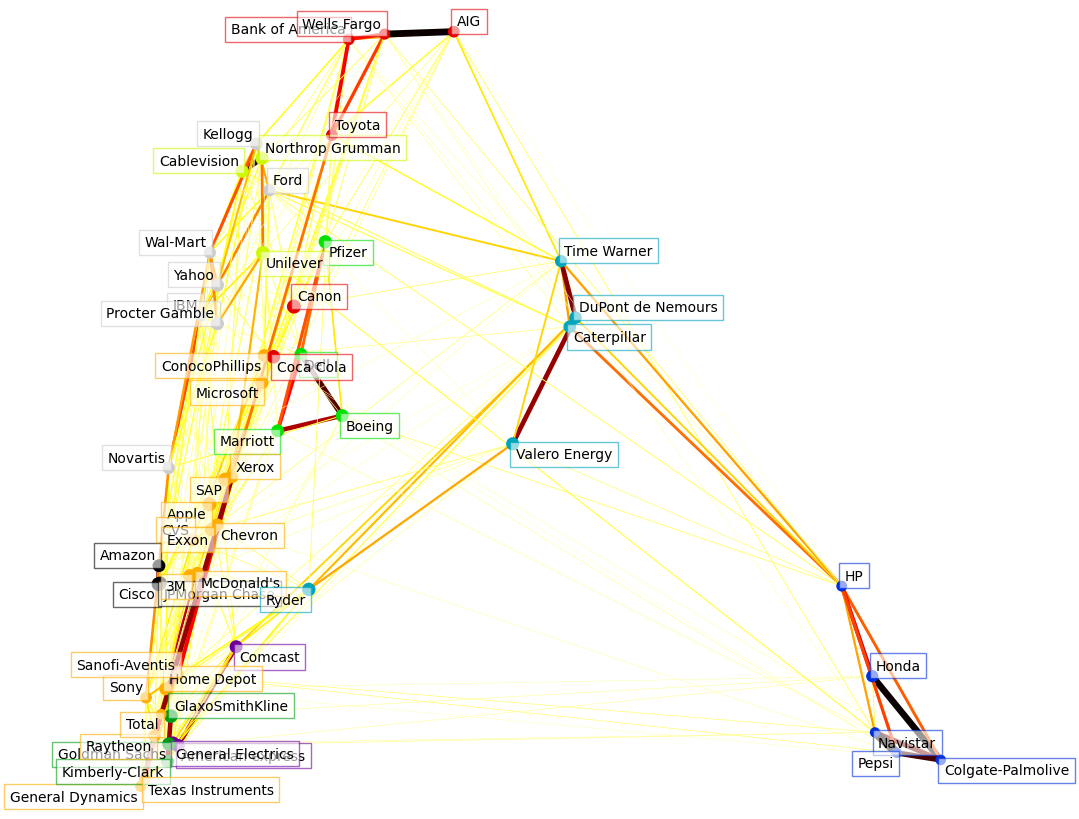

In [16]:
#
# Visualización
#
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))

plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Muestra la grafica de las correlaciones parciales
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Grafica los nodos usando las coordenadas del embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Grafica los bordes
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Adicional a etiqueta a cada nodo. El reto es posicionar las etiquetas
# para evitar que se traslapen con otras etiquetas
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()

In [17]:
plt.savefig("../files/output/stocks.png")

<Figure size 640x480 with 0 Axes>